In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

import methods

%load_ext autoreload
%autoreload 2

Tue Oct 27 10:10:23 PDT 2020


# Calculations for results section

## Load data files

In [2]:
data = methods.load_data()

/homes/abie/.conda/envs/vivarium_conic_sqlns/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
data['data_start_date'].strftime(methods.date_fmt), data['most_recent_data_date'].strftime(methods.date_fmt)

('September 6, 2020', 'October 18, 2020')

In [4]:
n_weeks = (data['most_recent_data_date'] - data['data_start_date']) / pd.Timedelta(days=7)
print(f'{n_weeks:.2f} weeks of data')

6.00 weeks of data


In [5]:
rows = (data['df'].date >= data['data_start_date']) & (data['df'].test_required == 1)
sum(rows)

40552

In [6]:
df = methods.subset_data(data, rows, exposure='hcw', outcome='test_positive')

# text for Results Section paragraph 1:

In [7]:
print(f'The survey data contained {len(df):,.0f} respondents who were tested due to workplace requirements '
      f'in the time period we focused on,'
      f' {df.exposure.sum():,.0f} HCWs and {(1-df.exposure).sum():,.0f} non-HCWs (see Table 1 for demographic details).'
      f' There were '
      f'{df.outcome.sum():,.0f} respondents who reported a positive test for COVID-19 in the last 14 days '
      f'({df[df.exposure==1].outcome.sum():,.0f} among HCWs and {df[df.exposure==0].outcome.sum():,.0f} among non-HCWs).')

The survey data contained 40,552 respondents who were tested due to workplace requirements in the time period we focused on, 13,747 HCWs and 26,805 non-HCWs (see Table 1 for demographic details). There were 1,993 respondents who reported a positive test for COVID-19 in the last 14 days (527 among HCWs and 1,466 among non-HCWs).


## Calculate relative risk with uncertainty

In [8]:
%%time

# set random seed for reproducibility
np.random.seed(12345)
rr_draws = methods.sample_rr_draws(df)
rr_draws

CPU times: user 1min 6s, sys: 156 ms, total: 1min 6s
Wall time: 1min 6s


point_est    0.693788
draw_0       0.719269
draw_1       0.701832
draw_2       0.676846
               ...   
draw_996     0.703117
draw_997     0.656673
draw_998     0.720599
draw_999     0.683855
Length: 1001, dtype: float64

In [9]:
rr_mean, rr_lb, rr_ub = methods.my_summarize(rr_draws)

In [10]:
print(f'Among HCWs with a required test, {df[df.exposure==1].outcome.sum():,.0f} of {df.exposure.sum():,.0f}'
      f' ({df[df.exposure==1].outcome.mean()*100:,.1f}%) reported a positive test in the last 14 days,'
      f' while among non-HCWs with a required test, '
      f'{df[df.exposure==0].outcome.sum():,.0f} of {(df.exposure==0).sum():,.0f}'
      f' ({df[df.exposure==0].outcome.mean()*100:,.1f}%) reported a positive test,'
      f' for a relative COVID-19 prevalence ratio of {rr_mean:.1f} (95% UI {rr_lb:.1f} to {rr_ub:.1f}).'
      )

Among HCWs with a required test, 527 of 13,747 (3.8%) reported a positive test in the last 14 days, while among non-HCWs with a required test, 1,466 of 26,805 (5.5%) reported a positive test, for a relative COVID-19 prevalence ratio of 0.7 (95% UI 0.6 to 0.8).


In [11]:
# table version of results
t = pd.DataFrame(index=[0])
t.loc[0, 'HCW - tested'] = f'{df.exposure.sum():,.0f}'
t.loc[0, 'HCW - positive'] = f'{df[df.exposure==1].outcome.sum():,.0f}'
t.loc[0, 'HCW - (%)'] = f'{df[df.exposure==1].outcome.mean()*100:,.1f}'

t.loc[0, 'non-HCW - tested'] = f'{(1-df.exposure).sum():,.0f}'
t.loc[0, 'non-HCW - positive'] = f'{df[df.exposure==0].outcome.sum():,.0f}'
t.loc[0, 'non-HCW - (%)'] = f'{df[df.exposure==0].outcome.mean()*100:,.1f}'

t.loc[0, 'RR'] = f'{rr_mean:.1f}'
t.loc[0, '95% UI'] = f'{rr_lb:.1f} to {rr_ub:.1f}'

t

,HCW - tested,HCW - positive,HCW - (%),non-HCW - tested,non-HCW - positive,non-HCW - (%),RR,95% UI
0,"13,747",527,3.8,"26,805","1,466",5.5,0.7,0.6 to 0.8


# Sensitivity analyses

## Unweighted version of main result

In [12]:
df['weight'] = 1
df['weighted_outcome'] = df.outcome

In [13]:
# set random seed for reproducibility
np.random.seed(12345)
unweighted_rr_draws = methods.sample_rr_draws(df)
methods.my_summarize(unweighted_rr_draws)

(0.7009459387443184, 0.6481467734657929, 0.74171366376853)

In [14]:
unweighted_rr_mean, unweighted_rr_lb, unweighted_rr_ub = \
    methods.my_summarize(unweighted_rr_draws)

In [15]:
print(f'When we did not use the sample weights to calculate the COVID-19 endorsement rates we found'
      f' a relative COVID-19 incidence ratio of {unweighted_rr_mean:.1f} '
      f'(95% UI {unweighted_rr_lb:.1f} to {unweighted_rr_ub:.1f}).'
      )

When we did not use the sample weights to calculate the COVID-19 endorsement rates we found a relative COVID-19 incidence ratio of 0.7 (95% UI 0.6 to 0.7).


## Sub-analyses for specific subsets of HCWs

To understand how the results might vary between subgroups of HCWs, we repeated our analysis restricted to only doctors, only nurses, only home health aides, and only medical assistants:

In [16]:
results = {}

In [17]:
rows = (data['df'].date >= data['data_start_date']) & (data['df'].test_required == 1)

In [18]:
df = methods.subset_data(data, rows, exposure='hcw', outcome='test_positive')
results['All HCWs'] = methods.my_calc_and_summarize(df)

In [19]:
df['exposure'] = (data['df'].loc[rows, 'Q68'] == 1)  # Physician or surgeon
results['Physician or surgeon'] = methods.my_calc_and_summarize(df)

In [20]:
df['exposure'] = (data['df'].loc[rows, 'Q68'] == 2)  # Registered nurse (including nurse practitioner)
results['Registered nurse (including nurse practitioner)'] = methods.my_calc_and_summarize(df)

In [21]:
df['exposure'] = (data['df'].loc[rows, 'Q68'] == 3) 
results['Licensed practical or licensed vocational nurse'] = methods.my_calc_and_summarize(df)

In [22]:
df['exposure'] = (data['df'].loc[rows, 'Q68'] == 4)
results['Physician assistant'] = methods.my_calc_and_summarize(df)

In [23]:
df['exposure'] = (data['df'].loc[rows, 'Q68'] == 5)
results['Dentist'] = methods.my_calc_and_summarize(df)

In [24]:
df['exposure'] = (data['df'].loc[rows, 'Q68'] == 6)
results['Any other treating practitioner'] = methods.my_calc_and_summarize(df)

In [25]:
df['exposure'] = (data['df'].loc[rows, 'Q68'] == 7)
results['Pharmacist'] = methods.my_calc_and_summarize(df)

In [26]:
df['exposure'] = (data['df'].loc[rows, 'Q68'] == 8)
results['Any therapist'] = methods.my_calc_and_summarize(df)

In [27]:
df['exposure'] = (data['df'].loc[rows, 'Q68'] == 9)
results['Any health technologist or technician'] = methods.my_calc_and_summarize(df)

In [28]:
df['exposure'] = (data['df'].loc[rows, 'Q68'] == 10)
results['Veterinarian'] = methods.my_calc_and_summarize(df)

In [29]:
df['exposure'] = (data['df'].loc[rows, 'Q69'] == 1)
results['Nursing assistant or psychiatric aide'] = methods.my_calc_and_summarize(df)

In [30]:
df['exposure'] = (data['df'].loc[rows, 'Q69'] == 2)
results['Home health or personal care aide'] = methods.my_calc_and_summarize(df)

In [31]:
df['exposure'] = (data['df'].loc[rows, 'Q69'] == 3)
results['Occupational or physical therapy assistant or aide'] = methods.my_calc_and_summarize(df)

In [32]:
df['exposure'] = (data['df'].loc[rows, 'Q69'] == 4)
results['Massage therapist'] = methods.my_calc_and_summarize(df)

In [33]:
df['exposure'] = (data['df'].loc[rows, 'Q69'] == 5)
results['Dental assistant'] = methods.my_calc_and_summarize(df)

In [34]:
df['exposure'] = (data['df'].loc[rows, 'Q69'] == 6)
results['Medical assistant'] = methods.my_calc_and_summarize(df)

In [35]:
df['exposure'] = (data['df'].loc[rows, 'Q69'] == 7)
results['Medical transcriptionist'] = methods.my_calc_and_summarize(df)

In [36]:
df['exposure'] = (data['df'].loc[rows, 'Q69'] == 8)
results['Pharmacy aide'] = methods.my_calc_and_summarize(df)

In [37]:
df['exposure'] = (data['df'].loc[rows, 'Q69'] == 9)
results['Phlebotomist'] = methods.my_calc_and_summarize(df)

In [38]:
df['exposure'] = (data['df'].loc[rows, 'Q69'] == 10)
results['Veterinary assistant'] = methods.my_calc_and_summarize(df)

In [39]:
df['exposure'] = (data['df'].loc[rows, 'Q69'] == 11)
results['Any other healthcare support worker'] = methods.my_calc_and_summarize(df)

In [40]:
hcw_types_results = pd.DataFrame(results).T
hcw_types_results.columns = 'n_nonHCW', 'n_HCW', 'RR', 'lb', 'ub'

In [41]:
pd.set_option('display.max_rows', 80)
np.round(hcw_types_results,2)

,n_nonHCW,n_HCW,RR,lb,ub
All HCWs,26805.0,13747.0,0.69,0.63,0.77
Physician or surgeon,40277.0,275.0,2.62,1.78,3.47
Registered nurse (including nurse practitioner),37573.0,2979.0,0.62,0.58,0.80
Licensed practical or licensed vocational nurse,38560.0,1992.0,0.63,0.53,0.78
Physician assistant,40405.0,147.0,0.66,0.37,1.26
Dentist,40518.0,34.0,0.38,0.00,0.83
Any other treating practitioner,40189.0,363.0,0.54,0.29,0.85
Pharmacist,40473.0,79.0,0.31,0.08,0.80
Any therapist,39371.0,1181.0,0.50,0.40,0.70
Any health technologist or technician,39062.0,1490.0,1.00,0.72,1.15


# Sensitivity analysis of those with required testing _and_ symptoms

Herbie writes:
> The one question I have at this point is how to account for work required testing.  I worry that there may be systematic differences in testing policies in the healthcare and non-healthcare setting.  Specifically, are individuals being tested because they are symptomatic, or is this part of routine testing?

To investigate this, we can dig deeper into the "why you were tested" question that we used to subset on the individuals who were tested because of employeer/educational requirements (value "4").

This question has a "select all that apply" answer, and includes "I felt sick" (value "1") as a response as well.

In [42]:
test_reason = data['df'].test_reason.fillna('')
required_testing_and_felt_sick_rows = (test_reason.str.contains("4")
                                       & test_reason.str.contains("1"))
sum(required_testing_and_felt_sick_rows)

4240

In [43]:
required_testing_and_not_felt_sick_rows = (test_reason.str.contains("4")
                                           & ~test_reason.str.contains("1"))
sum(required_testing_and_not_felt_sick_rows)

36312

In [44]:
results = {}

df = methods.subset_data(data, required_testing_and_not_felt_sick_rows, exposure='hcw', outcome='test_positive')
results['Test required, did not feel sick'] = methods.my_calc_and_summarize(df)

In [45]:
df = methods.subset_data(data, required_testing_and_felt_sick_rows, exposure='hcw', outcome='test_positive')
results['Test required, felt sick'] = methods.my_calc_and_summarize(df)

In [46]:
required_testing_results = pd.DataFrame(results).T
required_testing_results.columns = 'n_nonHCW', 'n_HCW', 'RR', 'lb', 'ub'
np.round(required_testing_results, 2)

,n_nonHCW,n_HCW,RR,lb,ub
"Test required, did not feel sick",23523.0,12789.0,1.05,0.97,1.24
"Test required, felt sick",3282.0,958.0,0.75,0.65,0.88


# Sensitivity analysis of those who work outside the home

Dan writes:
> HCW in this study encompasses a broad group that likely has varying hospital exposures. My sister-in-law is an OT who works from home currently. Do these study HCW represent the HCW that a patient encounters when seeking medical care?

The survey does contain some information about whether the workers are working from home, but it is pretty coarse, “Was any of your work for pay in the last four weeks outside your home?” I’m going to check if it changes any results though, because I bet it doesn’t (because who would be required to test if they were working from home?).

In [47]:
required_testing_and_outside_work = data['df'].test_required & (data['df'].work_outside_home == 1)
sum(required_testing_and_outside_work)

26690

In [48]:
required_testing_and_not_outside_work = data['df'].test_required & (data['df'].work_outside_home != 1)
sum(required_testing_and_not_outside_work)

13862

In [49]:
results = {}

df = methods.subset_data(data, required_testing_and_outside_work, exposure='hcw', outcome='test_positive')
results['Test required, worked outside of home'] = methods.my_calc_and_summarize(df)

In [50]:
df = methods.subset_data(data, required_testing_and_not_outside_work, exposure='hcw', outcome='test_positive')
results['Test required, did not work outside of home'] = methods.my_calc_and_summarize(df)

In [51]:
outside_work_results = pd.DataFrame(results).T
outside_work_results.columns = 'n_nonHCW', 'n_HCW', 'RR', 'lb', 'ub'
np.round(outside_work_results, 2)

,n_nonHCW,n_HCW,RR,lb,ub
"Test required, worked outside of home",14705.0,11985.0,0.76,0.69,0.86
"Test required, did not work outside of home",12100.0,1762.0,0.76,0.52,0.87


# For a different project, what is the RR of people who attend mass gatherings, compared to those who did not?

In [52]:
data['df']['mass_gathering'] = data['df'].test_reason.fillna('').str.contains('5')  # outdoor gathering
df = methods.subset_data(data, data['df'].test_required, exposure='mass_gathering', outcome='test_positive')
methods.my_calc_and_summarize(df)

[39421, 1131, 9.051658117321928, 8.221011045840653, 9.593836664868338]

In [53]:
data['df']['mass_gathering'] = data['df'].test_reason.fillna('').str.contains('6')  # indoor gathering
df = methods.subset_data(data, data['df'].test_required, exposure='mass_gathering', outcome='test_positive')
methods.my_calc_and_summarize(df)

[39187, 1365, 8.6731538518248, 8.017891312803105, 9.432661661710636]

# Results by week

In [54]:
results = {}

for week in range(6):
    week_end = data['most_recent_data_date'] - pd.Timedelta(days=7*week) 
    rows = ((data['df'].date <= week_end)
            & (data['df'].date > week_end - pd.Timedelta(days=7))
            & (data['df'].test_required == 1))
    print(f'Week ending {week_end.strftime(methods.date_fmt)}: {sum(rows)} rows')

    df = methods.subset_data(data, rows, exposure='hcw', outcome='test_positive')
    results[f'Week ending {week_end.strftime(methods.date_fmt)}'] = methods.my_calc_and_summarize(df)

Week ending October 18, 2020: 5836 rows
Week ending October 11, 2020: 7449 rows
Week ending October 4, 2020: 6944 rows
Week ending September 27, 2020: 6840 rows
Week ending September 20, 2020: 7117 rows
Week ending September 13, 2020: 6366 rows


In [55]:
by_week_results = pd.DataFrame(results).T
by_week_results.columns = 'n_nonHCW', 'n_HCW', 'RR', 'lb', 'ub'
np.round(by_week_results, 2)

,n_nonHCW,n_HCW,RR,lb,ub
"Week ending October 18, 2020",3910.0,1926.0,0.82,0.60,1.06
"Week ending October 11, 2020",4914.0,2535.0,0.80,0.60,1.02
"Week ending October 4, 2020",4567.0,2377.0,0.50,0.41,0.75
"Week ending September 27, 2020",4473.0,2367.0,0.64,0.45,0.79
"Week ending September 20, 2020",4682.0,2435.0,0.78,0.59,1.01
"Week ending September 13, 2020",4259.0,2107.0,0.62,0.43,0.78


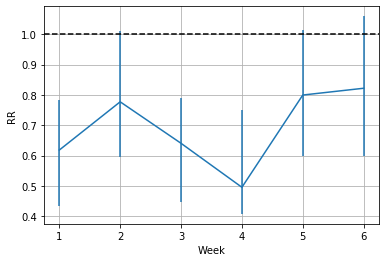

In [56]:
plt.errorbar(range(6,0,-1), by_week_results.RR, yerr=[by_week_results.RR-by_week_results.lb,
                                                      by_week_results.ub-by_week_results.RR,
                                                     ])
plt.axhline(1.0, color='k', linestyle='dashed')
plt.xlabel('Week')
plt.ylabel('RR')
plt.grid();

# For another question work from home vs not among all workers

In [57]:
df = methods.subset_data(data, data['df'].test_required, exposure='work_outside_home', outcome='test_positive')
methods.my_calc_and_summarize(df)

[13862, 26690, 0.7268458093211172, 0.6701185336299073, 0.7823602851011704]

In [58]:
df = methods.subset_data(data, data['df'].test_required, exposure='work_outside_home', outcome='test_negative')
methods.my_calc_and_summarize(df)

[13862, 26690, 1.0330929001859022, 1.0285910470981687, 1.0441984239622961]